# Libraries

In [54]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import warnings

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import string
import nltk
nltk.download('stopwords')
import shutil
from scipy.stats import chi2_contingency


import seaborn as sns
import matplotlib.pylab as plt

from datetime import datetime, timedelta
from tqdm import tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/halledavis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Load

In [2]:
#os.chdir('C:\\Users\\halle.davis\\Downloads\\') ## Halle's work folder path
os.chdir('/Users/halledavis/Downloads/') ## Halle's personal folder path
#os.chdir('/users/clairephibbs/Desktop/') ## Claire's folder path
#os.chdir('/Users/summerpurschke/Desktop/ADS/Capstone') ## Summer's folder path

In [3]:
inspections = pd.read_csv('Inspections.txt', sep= '|', encoding = 'latin-1')
mines = pd.read_csv('Mines.txt', sep= '|', encoding = 'latin-1')
accidents = pd.read_csv('Accidents.txt', sep= '|', encoding = 'latin-1')
violations = pd.read_csv('Violations.txt', sep= '|', encoding = 'latin-1')

/var/folders/4w/bl1whnz1491dljnl9k34l06h0000gn/T/ipykernel_4283/3089229011.py:3: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv('Accidents.txt', sep= '|', encoding = 'latin-1')
/var/folders/4w/bl1whnz1491dljnl9k34l06h0000gn/T/ipykernel_4283/3089229011.py:4: DtypeWarning: Columns (25,34,36,37,43,45,46,55,56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  violations = pd.read_csv('Violations.txt', sep= '|', encoding = 'latin-1')


### Dataset Description - Violations 
1. EVENT_NO (VARCHAR2): A preassigned number used to identify each inspection, investigation, audit, survey, etc.  Use event_no to join to the Inspections table which can be joined to the Mines table with mine_id.
2. INSPECTION_BEGIN_DT (DATE): Start date of the inspection (mm/dd/yyyy).
3. INSPECTION_END_DT (DATE): Inspection close out date (mm/dd/yyyy).
4. VIOLATION_NO (VARCHAR2): Citation/order number assigned to each citation written during an inspection.  This is a unique key to the file.
5. CONTROLLER_ID (VARCHAR2): Identification number assigned by MSHA Assessments for a Legal Entity acting as a controller of an operator at the time the violation was cited. May contain null values if this record pertains to a violation issued to a contractor.
6. CONTROLLER_NAME (VARCHAR2): Name of the controller active at the time the violation was cited.  May contain null values if this record pertains to a violation issued to a contractor.
7. VIOLATOR_ID (VARCHAR2): Identification number assigned by MSHA for a Legal Entity acting as an operator at a mine at the time the violation was cited. May contain null values if this record pertains to a violation issued to a contractor.
8. VIOLATOR_NAME (VARCHAR2): Name of the operator active at the time the violation was cited.  May contain null values if this record pertains to a violation issued to a contractor.
9. VIOLATOR_TYPE_CD (VARCHAR2): Each Violator record represents an entity (Operator, Contractor, Agent or Miner) that has one or more violations at a mine.
10. MINE_ID (VARCHAR2): Mine id of the mine where the violation was issued.  Can use the mine_id to join to the Mines table.  
11. MINE_NAME (VARCHAR2): Name of the mine where the violation was issued.
12. MINE_TYPE (VARCHAR2): Mine type of the mine where the violation has been issued:  Facility, Surface or Underground.
13. COAL_METAL_IND (VARCHAR2): Identifies if the record is for a Coal or Metal/Non-Metal mine.
14. CONTRACTOR_ID (VARCHAR2): Code identifying the contractor to whom the citation or order was issued.  May contain null values if the contractor was not cited.
15. VIOLATION_ISSUE_DT (DATE): Date the citation or order was issued by the MSHA inspector.
16. VIOLATION_OCCUR_DT (DATE): Actual date of occurrence of the violation.  
17. CAL_YR (NUMBER): Calendar year during which the citation/order was issued by the MSHA inspector.
18. CAL_QTR (NUMBER): Calendar Quarter of the date the citation or order was issued by the MSHA inspector.
19. FISCAL_YR (NUMBER): Fiscal Year of the date the citation or order was issued by the MSHA inspector.  MSHA's fiscal year begins October 1 and ends September 30.
20. FISCAL_QTR (NUMBER): Fiscal Quarter of the date the citation or order was issued by the MSHA inspector.
21. VIOLATION_ISSUE_TIME (VARCHAR2): Time (24 hour) the citation or order was issued by the MSHA inspector.
22. SIG_SUB (VARCHAR2): An indicator as to whether or not the gravity is determined by the inspector to be significant and substantial.  If this is 'Y', the inspector has indicated that based upon the particular facts surrounding the violation there exists a reasonable likelihood the hazard contributed to will result in an injury or illness of a reasonably serious nature.
23. SECTION_OF_ACT (VARCHAR2): Section of the Act under which the citation/order was issued.  May contain null values.
24. PART_SECTION (VARCHAR2): Code of Federal Regulations: Part/section of Title 30 CFR violated in format PPSSSSSXXXX where (P) Part, (S) Section and (X) Suffix.  Four-digit section numbers are expanded to five within one leading zero.  May contain null values.
25. SECTION_OF_ACT_1 (VARCHAR2): Primary Section of Act which gives the MSHA Inspector the authority to take the action specified by this Issuance.   More than one type of action may be cited.
26. SECTION_OF_ACT_2 (VARCHAR2): Secondary Section of Act which gives the MSHA Inspector the authority to take the action specified by this Issuance at Metal/Non-Metal mines only.  More than one type of action may be cited.
27. CIT_ORD_SAFE (VARCHAR2): Specifies the type of Citation: Citation, Order, Safeguard, Written Notice or Notice.
28. ORIG_TERM_DUE_DT (DATE): Original date by which the cited condition was to be abated.  Original time by which the cited condition was to be abated. 
29. ORIG_TERM_DUE_TIME (VARCHAR2): Original time by which the cited condition was to be abated.   
30. LATEST_TERM_DUE_DT (DATE): Date by which the conditions cited in the citation/order are to be abated.  For Metal mines, this can be the termination due date to which the citation/order is extended.  
31. LATEST_TERM_DUE_TIME (VARCHAR2): Time by which the conditions cited on the citation/order are to be abated.  
32. TERMINATION_DT (DATE): Date on which the citation/order was terminated.  May contain null values if citation has not yet been terminated.
33. TERMINATION_TIME (VARCHAR2): Time of day (24 hour) at which the citation/order was terminated.  May contain null values if citation has not yet been terminated.
34. TERMINATION_TYPE (VARCHAR2): Code identifying the type of termination:  Issued, ReplacedByOrder or Terminated.
35. VACATE_DT (DATE): Date on which the citation/order was vacated.  May contain null values if the violation was not vacated.
36. VACATE_TIME (VARCHAR2): Time of day (24 hour) at which the citation/order was vacated.  May contain null values if the violation was not vacated.
37. INITIAL_VIOL_NO (VARCHAR2): This is the preceding citation record when there is a need to relate a citation to a previous one. For example this would apply when an order follows a citation. This relationship is needed to calculate the good faith reduction penalty points.  May contain null values.
38. REPLACED_BY_ORDER_NO (VARCHAR2): Order number which replaced the original citation.  May contain null values if situation does not apply.
39. LIKELIHOOD (VARCHAR2): This is a measure of the seriousness of the violation being cited as measured by the likelihood of the occurrence of an accident:  Highly, NoLikelihood, Occurred, Reasonably or Unlikely. May contain null values if situation does not apply.
40. INJ_ILLNESS (VARCHAR2): Value assigned to a violation for gravity of injury.  Measure of seriousness of violation being cited as measured by severity of the injury or illness to persons if accident were to occur due to the conditions of the violation: Fatal, LostDays, NoLostDays or Permanent.
41. NO_AFFECTED (NUMBER): This is a measure of the number of persons affected or potentially affected by the conditions at the Mine due to the violation.  Can be zero.
42. NEGLIGENCE (VARCHAR2): Codes representing the degree of negligence that the Inspector assigned to the violator due to the violation:  HighNegligence, LowNegligence, ModNegligence, NoNegligence or Reckless. A high degree of negligence is assigned when the operator was in a position to be aware of the condition that contributed to a dangerous situation and there were no mitigating circumstances, or if there are unique aggravating circumstances associated with the violation, such as repeated past violations of the same standard at the mine.
43. WRITTEN_NOTICE (VARCHAR2): Indicates if this citation is a result of a Miner or Agent notice of complaint to MSHA (written notice 103(g)):  ('Y'  or 'N').  May contain null values.
44. ENFORCEMENT_AREA (VARCHAR2): Specifies the enforcement areas affected by the violating condition or practice constitute a health hazard, safety hazard, both or other type of hazard. May contain null values.
45. SPECIAL_ASSESS (VARCHAR2): Specifies whether this citation has been designated for Special Assessment based on Special Assessment Review (Y or N).
46. PRIMARY_OR_MILL (VARCHAR2): A code indicating if the Violation was observed in the Primary Mine location or in an associated Mill (Metal/Non-Metal only). May contain null values.
47. RIGHT_TO_CONF_DT (DATE): Date the operator was advised of his right to a conference (Metal/Non-Metal only).  May contain null values.
48. ASMT_GENERATED_IND (VARCHAR2): If the violator is an Operator or Contractor, the indicator is 'N'. If the violator is an Agent, the indicator is 'Y'. If the violator is a Miner, the indicator can be 'Y' or 'N'. If none of the above, the indicator is '?'.
49. FINAL_ORDER_ISSUE_DT (DATE): Date that this assessment becomes a Final Order.  This date is set when the Certified Return Receipt date (CRR) is set.  Note that this can be a projected future date that is set as soon as the CRR is entered.  
50. PROPOSED_PENALTY (NUMBER): The original dollar value of the proposed penalty prior to any modifications such as those possibly resulting from a decision on a contested case.
51. AMOUNT_DUE (NUMBER): The current dollar value of the proposed assessment, reflecting any modifications that have been made since it was originally assessed.
52. AMOUNT_PAID (NUMBER): The total dollar value of all payments applied to this proposed assessment to date.
53. BILL_PRINT_DT (DATE): Date the bill was printed.  This date always represents the first time the bill was printed.
54. LAST_ACTION_CD (VARCHAR2): Last action taken against this violation such as 1stDemandPrinted, BillingReady, ApprovedforTreasury and Proposed.  
55. LAST_ACTION_DT (DATE): Date the last action taken against this violation.
56. DOCKET_NO (VARCHAR2): The Docket Number assigned by the Court to this group of Assessments being contested.
57. DOCKET_STATUS_CD (VARCHAR2): Denotes the current status of this docket:  Approved (approved by the court) or Proposed (not yet been approved by the court).
58. CONTESTED_IND (VARCHAR2): Indicates if this violation has been assessed and is being contested (Y or N).
59. CONTESTED_DT (DATE): Date of the most recent docket status for this violation.
60. VIOLATOR_VIOLATION_CNT (NUMBER): Total number of assessed violations for this violator at this time during the violation history period. Used in penalty calculation.  Applies to an Operator or a Contractor.
61. VIOLATOR_INSPECTION_DAY_CNT (NUMBER): Total number of inspections for this Operator at a mine during the violation history period. Used in penalty calculation. Does not apply to Contractor.

# EDA (Exploratory Data Analysis)

## Violations Dataset

### Initial Peek at Data

In [4]:
violations.head() # head

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,DOCKET_NO,DOCKET_STATUS_CD,CONTESTED_IND,CONTESTED_DT,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,01/04/2000,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
1,711256,01/04/2000,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
2,711256,01/04/2000,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
3,711256,01/04/2000,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,196.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
4,711256,01/04/2000,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0


In [5]:
print(violations.shape) # shape

(2814877, 61)


INSIGHT: We have more than 2 million rows (almost 3 million) and 61 columns.

In [6]:
violations.describe() # description

,EVENT_NO,VIOLATION_NO,MINE_ID,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,VIOLATION_ISSUE_TIME,ORIG_TERM_DUE_TIME,LATEST_TERM_DUE_TIME,TERMINATION_TIME,VACATE_TIME,NO_AFFECTED,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
count,2.814877e+06,2.814877e+06,2.814877e+06,2.814877e+06,2.814877e+06,2.814877e+06,2.814877e+06,2.814877e+06,2.137024e+06,2.720495e+06,2.796281e+06,70.000000,2.814877e+06,2.752320e+06,2.752320e+06,2.752320e+06,2.752320e+06,2.752320e+06
mean,4.465154e+06,7.855610e+06,2.698092e+06,2.010455e+03,2.441416e+00,2.010679e+03,2.546844e+00,1.123202e+03,1.217976e+03,1.200544e+03,1.152244e+03,22.157143,1.481686e+00,5.891074e+02,4.721570e+02,4.069207e+02,1.231456e+02,1.675176e+02
std,2.214657e+06,1.185013e+06,1.552261e+06,6.288793e+00,1.102928e+00,6.292951e+00,1.098157e+00,3.106849e+02,3.742661e+02,3.763969e+02,3.180759e+02,185.379957,6.264660e+00,3.111021e+03,2.254306e+03,1.886742e+03,2.281789e+02,3.013523e+02
min,3.206180e+05,7.299270e+05,1.000030e+05,1.994000e+03,1.000000e+00,1.994000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.041921e+06,7.045106e+06,1.509571e+06,2.006000e+03,1.000000e+00,2.006000e+03,2.000000e+00,9.300000e+02,9.000000e+02,9.000000e+02,9.350000e+02,0.000000,1.000000e+00,1.000000e+02,1.000000e+02,6.000000e+01,1.000000e+00,1.000000e+00
50%,4.414561e+06,8.043402e+06,2.602246e+06,2.010000e+03,2.000000e+00,2.010000e+03,3.000000e+00,1.100000e+03,1.200000e+03,1.200000e+03,1.125000e+03,0.000000,1.000000e+00,1.230000e+02,1.230000e+02,1.170000e+02,1.500000e+01,1.800000e+01
75%,6.542651e+06,8.819866e+06,4.405101e+06,2.015000e+03,3.000000e+00,2.016000e+03,4.000000e+00,1.302000e+03,1.500000e+03,1.500000e+03,1.335000e+03,0.000000,1.000000e+00,3.080000e+02,2.860000e+02,2.630000e+02,1.350000e+02,1.790000e+02
max,8.890948e+06,9.988780e+06,5.500013e+06,2.023000e+03,4.000000e+00,2.023000e+03,4.000000e+00,2.359000e+03,2.359000e+03,2.359000e+03,2.359000e+03,1551.000000,9.990000e+02,2.462000e+05,2.462000e+05,2.200000e+05,2.452000e+03,3.044000e+03


INSIGHT: There's a lot of garbage in here (ID's and dates) so we'll wait until numeric EDA to comment further.

In [7]:
violations.info() # data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2814877 entries, 0 to 2814876
Data columns (total 61 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   EVENT_NO                     int64  
 1   INSPECTION_BEGIN_DT          object 
 2   INSPECTION_END_DT            object 
 3   VIOLATION_NO                 int64  
 4   CONTROLLER_ID                object 
 5   CONTROLLER_NAME              object 
 6   VIOLATOR_ID                  object 
 7   VIOLATOR_NAME                object 
 8   VIOLATOR_TYPE_CD             object 
 9   MINE_ID                      int64  
 10  MINE_NAME                    object 
 11  MINE_TYPE                    object 
 12  COAL_METAL_IND               object 
 13  CONTRACTOR_ID                object 
 14  VIOLATION_ISSUE_DT           object 
 15  VIOLATION_OCCUR_DT           object 
 16  CAL_YR                       int64  
 17  CAL_QTR                      int64  
 18  FISCAL_YR                    int64  
 19  

In [8]:
# Create dataframe of missing values
violations_missing = pd.DataFrame(violations.isna().sum()).reset_index().rename(columns = {'index':'column', 0:'Missing Values'})

# Create new column for % Missing values 
violations_missing['% Missing'] = round(((violations_missing['Missing Values'] / violations.shape[0])*100),2)

# Show only columns with missing values 
violations_missing[violations_missing['Missing Values'] >0][['column', '% Missing']]
violations_missing

,column,Missing Values,% Missing
0,EVENT_NO,0,0.00
1,INSPECTION_BEGIN_DT,0,0.00
2,INSPECTION_END_DT,7606,0.27
3,VIOLATION_NO,0,0.00
4,CONTROLLER_ID,192275,6.83
...,...,...,...
56,DOCKET_STATUS_CD,2621958,93.15
57,CONTESTED_IND,0,0.00
58,CONTESTED_DT,2621958,93.15
59,VIOLATOR_VIOLATION_CNT,62557,2.22


INSIGHT: Some columns have nearly all nulls. Need to see if those nulls are true and the columns are relevant and create a plan to get rid of nulls (e.g. imputation).

Text(0.5, 1.0, 'Count of Violations over Time')

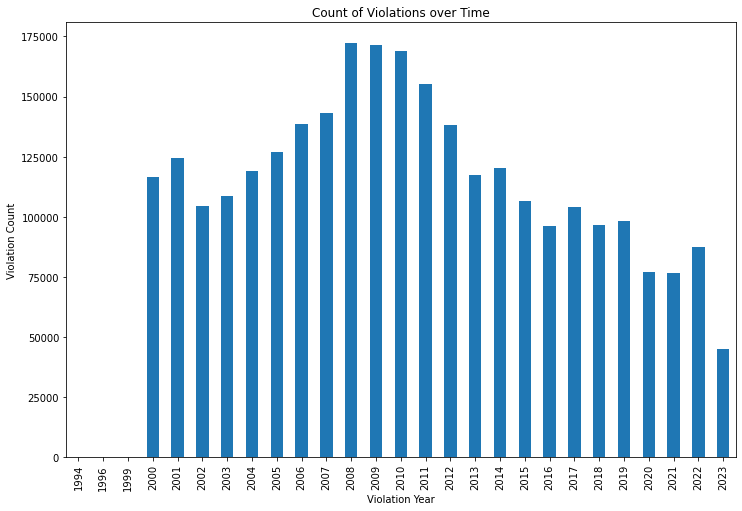

In [9]:
# convert column to datetime
violations['Date'] = pd.to_datetime(violations['VIOLATION_ISSUE_DT'])

# create a representation of the month with strfmt
violations['ymaccident'] = violations['Date'].map(lambda dt: dt.strftime('%Y-%m'))

grouped_df = violations.groupby('CAL_YR').size().to_frame("count").reset_index()

grouped_df.plot(kind='bar', x='CAL_YR', y='count', legend = None, figsize=(12,8))
plt.xlabel('Violation Year')
plt.ylabel('Violation Count')
plt.title('Count of Violations over Time')


### Numeric EDA

#### Overall Visualization

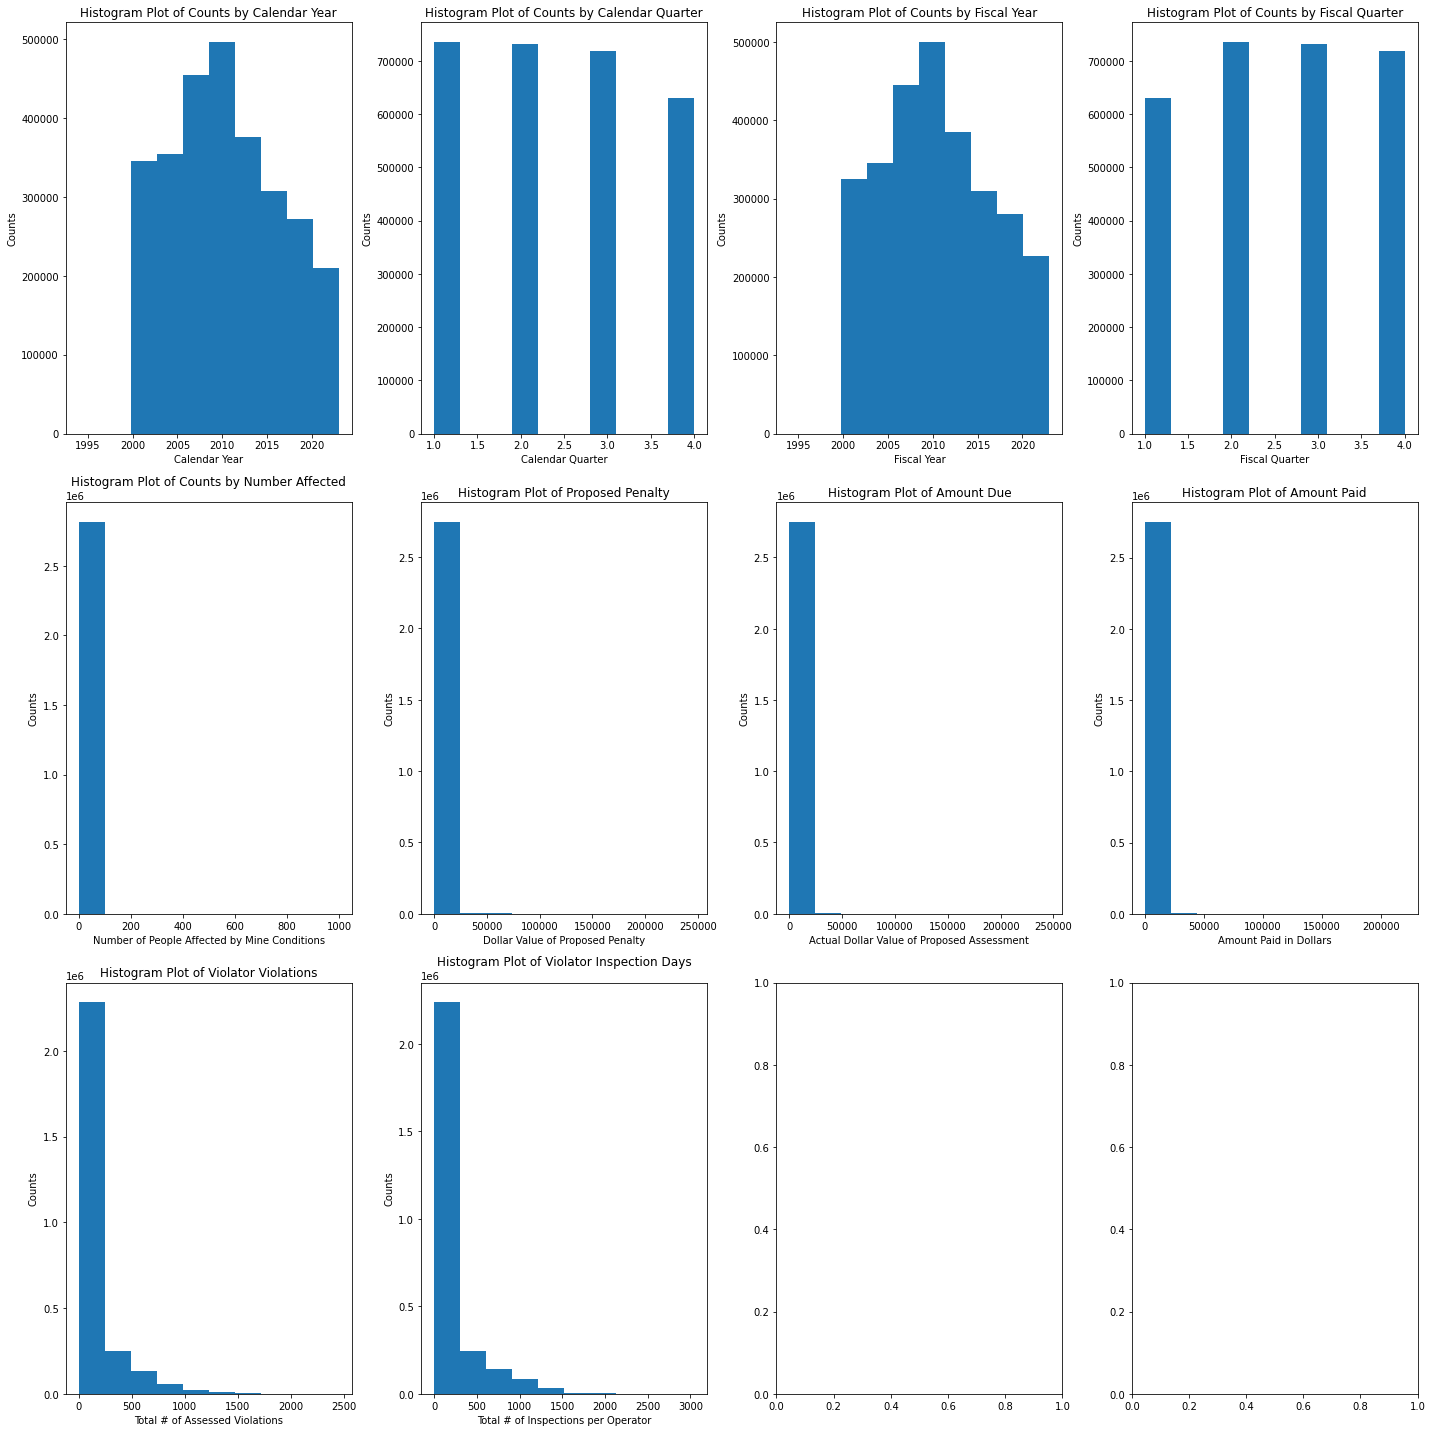

In [10]:
# scatter plots of numberical variables in violations df

fig, axs = plt.subplots(3, 4, figsize = (20, 20))

# cal_yr histogram
axs[0,0].hist(violations['CAL_YR'])
axs[0,0].set_xlabel('Calendar Year')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_title('Histogram Plot of Counts by Calendar Year')

# cal_qtr histogram
axs[0,1].hist(violations['CAL_QTR'])
axs[0,1].set_xlabel('Calendar Quarter')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_title('Histogram Plot of Counts by Calendar Quarter')

# fiscal_yr histogram
axs[0,2].hist(violations['FISCAL_YR'])
axs[0,2].set_xlabel('Fiscal Year')
axs[0,2].set_ylabel('Counts')
axs[0,2].set_title('Histogram Plot of Counts by Fiscal Year')

# fiscal_qtr histogram
axs[0,3].hist(violations['FISCAL_QTR'])
axs[0,3].set_xlabel('Fiscal Quarter')
axs[0,3].set_ylabel('Counts')
axs[0,3].set_title('Histogram Plot of Counts by Fiscal Quarter')

# no_affected histogram
axs[1,0].hist(violations['NO_AFFECTED'])
axs[1,0].set_xlabel('Number of People Affected by Mine Conditions')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_title('Histogram Plot of Counts by Number Affected')

# proposed_penalty histogram
axs[1,1].hist(violations['PROPOSED_PENALTY'])
axs[1,1].set_xlabel('Dollar Value of Proposed Penalty')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_title('Histogram Plot of Proposed Penalty')

# amount_due histogram
axs[1,2].hist(violations['AMOUNT_DUE'])
axs[1,2].set_xlabel('Actual Dollar Value of Proposed Assessment')
axs[1,2].set_ylabel('Counts')
axs[1,2].set_title('Histogram Plot of Amount Due')

# amount_paid histogram
axs[1,3].hist(violations['AMOUNT_PAID'])
axs[1,3].set_xlabel('Amount Paid in Dollars')
axs[1,3].set_ylabel('Counts')
axs[1,3].set_title('Histogram Plot of Amount Paid')

# violator_violation_cnt histogram
axs[2,0].hist(violations['VIOLATOR_VIOLATION_CNT'])
axs[2,0].set_xlabel('Total # of Assessed Violations')
axs[2,0].set_ylabel('Counts')
axs[2,0].set_title('Histogram Plot of Violator Violations')

# violator_inspection_day_cnt histogram
axs[2,1].hist(violations['VIOLATOR_INSPECTION_DAY_CNT'])
axs[2,1].set_xlabel('Total # of Inspections per Operator')
axs[2,1].set_ylabel('Counts')
axs[2,1].set_title('Histogram Plot of Violator Inspection Days')

plt.tight_layout()
plt.show()

INSIGHTS 

Violations are going down (since 2010 really).

There are less violations in Q4 (might need to remove 2023 to confirm that).

All other graphs are heavily right skewed. Need to dive in further to see if there are any outliers that need to be removed and what the real data picture is.

#### Number Affected

This is a measure of the number of persons affected or potentially affected by the conditions at the Mine due to the violation.  Can be zero.

In [11]:
violations.NO_AFFECTED.describe()

count    2.814877e+06
mean     1.481686e+00
std      6.264660e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.990000e+02
Name: NO_AFFECTED, dtype: float64

In [12]:
print(f"Skewness: {violations['NO_AFFECTED'].skew()}")
print(f"Kurtosis: {violations['NO_AFFECTED'].kurt()}")

Skewness: 123.22386290696603
Kurtosis: 18957.89644362109


INSIGHT: The average number affected is 1.5. The min is 0. The max is 999 - might want to look into that violation.
    
- There are 20 violations with max NO_AFFECTED == 999. I want to say this is a null value but there are also records with 998, 991, 900, etc. 

In [13]:
#violations[violations['NO_AFFECTED'] == 999]
no_affected_counts = pd.DataFrame(violations['NO_AFFECTED'].value_counts()).reset_index()
no_affected_counts.sort_values(by = 'NO_AFFECTED', ascending= False).head(5)

,NO_AFFECTED,count
61,999,20
41,998,59
128,991,2
209,900,1
158,812,1


In [14]:
max_index = violations[['NO_AFFECTED']].idxmax()
max_value = violations['NO_AFFECTED'].iloc[max_index[0]]
print(f"The largest value of NO_AFFECTED is at index : {max_index[0]}, with a value of: {max_value}")

The largest value of NO_AFFECTED is at index : 2356982, with a value of: 999


In [15]:
# pd.set_option('display.max_rows', None)

# print(violations[['NO_AFFECTED']].idxmax())
# print(violations.iloc[2356982])

# pd.reset_option('display.max_rows')

#### Proposed Penalty

The original dollar value of the proposed penalty prior to any modifications such as those possibly resulting from a decision on a contested case.

In [16]:
violations.PROPOSED_PENALTY.describe()

count    2.752320e+06
mean     5.891074e+02
std      3.111021e+03
min      1.000000e+00
25%      1.000000e+02
50%      1.230000e+02
75%      3.080000e+02
max      2.462000e+05
Name: PROPOSED_PENALTY, dtype: float64

In [17]:
print(f"Skewness: {violations['PROPOSED_PENALTY'].skew()}")
print(f"Kurtosis: {violations['PROPOSED_PENALTY'].kurt()}")

Skewness: 25.35834847277272
Kurtosis: 1038.4529724247518


INSIGHT: The average proposed penalty is 589.10 dollars. The min is 100 dollars and the max is 246,200 dollars - might want to look into that violation.

In [18]:
max_index = violations[['PROPOSED_PENALTY']].idxmax()
max_value = violations['PROPOSED_PENALTY'].iloc[max_index[0]]
print(f"The largest value of PROPOSED_PENALTY is at index : {max_index[0]}, with a value of: ${max_value}")

The largest value of PROPOSED_PENALTY is at index : 498123, with a value of: $246200.0


In [19]:
# pd.set_option('display.max_rows', None)

# print(violations[['PROPOSED_PENALTY']].idxmax())
# print(violations.iloc[498123])

# pd.reset_option('display.max_rows')

INSIGHT: The violation with the highest penalty is a highly likekly, fatal accident that waas characterized by reckless negligence.

#### Amount Due

The current dollar value of the proposed assessment, reflecting any modifications that have been made since it was originally assessed.

In [20]:
violations.AMOUNT_DUE.describe()

count    2.752320e+06
mean     4.721570e+02
std      2.254306e+03
min      0.000000e+00
25%      1.000000e+02
50%      1.230000e+02
75%      2.860000e+02
max      2.462000e+05
Name: AMOUNT_DUE, dtype: float64

In [21]:
print(f"Skewness: {violations['AMOUNT_DUE'].skew()}")
print(f"Kurtosis: {violations['AMOUNT_DUE'].kurt()}")

Skewness: 31.60113307522931
Kurtosis: 1819.4969349424239


In [22]:
max_index = violations[['AMOUNT_DUE']].idxmax()
max_value = violations['AMOUNT_DUE'].iloc[max_index[0]]
print(f"The largest value of AMOUNT_DUE is at index : {max_index[0]}, with a value of: ${max_value}")

The largest value of AMOUNT_DUE is at index : 498123, with a value of: $246200.0


INSIGHT: The average amount due is 472.15 dollars. The min is 0 dollars and the max is 246,200 dollars.

#### Amount Paid

The total dollar value of all payments applied to this proposed assessment to date.

In [23]:
violations.AMOUNT_PAID.describe()

count    2.752320e+06
mean     4.069207e+02
std      1.886742e+03
min      0.000000e+00
25%      6.000000e+01
50%      1.170000e+02
75%      2.630000e+02
max      2.200000e+05
Name: AMOUNT_PAID, dtype: float64

In [24]:
print(f"Skewness: {violations['AMOUNT_PAID'].skew()}")
print(f"Kurtosis: {violations['AMOUNT_PAID'].kurt()}")

Skewness: 36.29273547319254
Kurtosis: 2641.5993557580223


INSIGHT: The average amount paid is 406.92 dollars. The min is 0 dollars and the max is 220,000 dollars.

#### Violator Violations

Total number of assessed violations for this violator at this time during the violation history period. Used in penalty calculation.  Applies to an Operator or a Contractor.

In [25]:
violations.VIOLATOR_VIOLATION_CNT.describe()

count    2.752320e+06
mean     1.231456e+02
std      2.281789e+02
min      0.000000e+00
25%      1.000000e+00
50%      1.500000e+01
75%      1.350000e+02
max      2.452000e+03
Name: VIOLATOR_VIOLATION_CNT, dtype: float64

In [26]:
print(f"Skewness: {violations['VIOLATOR_VIOLATION_CNT'].skew()}")
print(f"Kurtosis: {violations['VIOLATOR_VIOLATION_CNT'].kurt()}")

Skewness: 2.862044414106103
Kurtosis: 10.344632494860818


INSIGHT: The average number of violations is 123. The min is 0 and the max is 2452. That's a lot of violations!

#### Violator Inspection Days

Total number of inspections for this Operator at a mine during the violation history period. Used in penalty calculation. Does not apply to Contractor.

In [27]:
violations.VIOLATOR_INSPECTION_DAY_CNT.describe()

count    2.752320e+06
mean     1.675176e+02
std      3.013523e+02
min      0.000000e+00
25%      1.000000e+00
50%      1.800000e+01
75%      1.790000e+02
max      3.044000e+03
Name: VIOLATOR_INSPECTION_DAY_CNT, dtype: float64

In [28]:
print(f"Skewness: {violations['VIOLATOR_INSPECTION_DAY_CNT'].skew()}")
print(f"Kurtosis: {violations['VIOLATOR_INSPECTION_DAY_CNT'].kurt()}")

Skewness: 2.4340972318566485
Kurtosis: 6.368570495121238


INSIGHT: The average number of inspections is 167. The min is 0 and the max is 3044. That's a lot of inspections!

#### Pairwise Plots

In [30]:
numeric_vars = violations[['NO_AFFECTED', 'PROPOSED_PENALTY', 'AMOUNT_DUE', 'AMOUNT_PAID', 'VIOLATOR_VIOLATION_CNT', 'VIOLATOR_INSPECTION_DAY_CNT']]
#sns.pairplot(numeric_vars)
#plt.show()

#### Correlation

In [ ]:
numeric_vars = violations[['CAL_YR', 'CAL_QTR', 'FISCAL_YR', 'FISCAL_QTR', 'NO_AFFECTED', 'PROPOSED_PENALTY', 'AMOUNT_DUE', 'AMOUNT_PAID', 'VIOLATOR_VIOLATION_CNT', 'VIOLATOR_INSPECTION_DAY_CNT']]
corr_matrix = numeric_vars.corr()

# Set the figure size to prevent overlapping
plt.figure(figsize=(10, 8))

# Create and show heatmap - add fontsize parameter
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={'fontsize': 10})
plt.title('Correlation Matrix of Numeric Variables')
plt.show()

In [ ]:
import winsound
winsound.Beep(400, 1000)

In [ ]:
numeric_vars = violations[['CAL_YR', 'CAL_QTR', 'FISCAL_YR', 'FISCAL_QTR', 'NO_AFFECTED', 'PROPOSED_PENALTY', 'AMOUNT_DUE', 'AMOUNT_PAID', 'VIOLATOR_VIOLATION_CNT', 'VIOLATOR_INSPECTION_DAY_CNT']]
plt.subplots(figsize=(20,10))
sns.heatmap(numeric_vars.corr(), annot = True, fmt = ".2f", cmap = "viridis");

NOTE: 
- PROPOSED_PENALTY and AMOUNT_DUE have a correleation coefficient of 0.88, indicating a high degree of correlation between the two variables. 
- Proposed penalty is the original dollar amount of the proposed penalty prior to any modifications, while amount due is the current dollar value of the proposed assessment, reflecting any modeifications made since the original assessment. 
- Given that the two are highly correlated, it seems that there is some type of relationship between perceived cause and actual cause of the accidents. 

INSIGHTS: 

Need to remove either FISCAL or CAL, not getting new info there.

I would argue number of affected is one of our key numeric variables and it doesnt seem at all correlated with any other numerical variable.

Amount paid, amount due, and proposed penalty are correlated, which makes sense.

Number of violations (VIOLATOR_VIOLATION_CNT) is supposed to inform penalties and their correlation is a mere 0.10. 

### Categorical EDA

#### Overall Visualizations

In [ ]:
# bar plots of categorical and binary variables in violations df

fig, axs = plt.subplots(4, 4, figsize = (20, 20))

# violator_type_cd bar chart
violations['VIOLATOR_TYPE_CD'].value_counts().plot(kind = 'bar', ax = axs[0,0])
axs[0,0].set_xlabel('Type of Violator')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_title('Bar Plot of Counts by Each Type of Violator')

# mine_type bar chart
violations['MINE_TYPE'].value_counts().plot(kind = 'bar', ax = axs[0,1])
axs[0,1].set_xlabel('Type of Mine')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_title('Bar Plot of Counts by Each Type of Mine')

# coal_metal_ind bar chart
violations['COAL_METAL_IND'].value_counts().plot(kind = 'bar', ax = axs[0,2])
axs[0,2].set_xlabel('Coal or Metal/Nonmetal Mine')
axs[0,2].set_ylabel('Counts')
axs[0,2].set_title('Bar Plot of Counts by Each Type of Mine')

# Sig_sub bar chart
violations['SIG_SUB'].value_counts().plot(kind = 'bar', ax = axs[0,3])
axs[0,3].set_xlabel('gravity indicator(y/n)')
axs[0,3].set_ylabel('Counts')
axs[0,3].set_title('Bar Plot of Whether Significant or Not')

# city_ord_safe bar chart
violations['CIT_ORD_SAFE'].value_counts().plot(kind = 'bar', ax = axs[1,0])
axs[1,0].set_xlabel('Type of Citation')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_title('Bar Plot of Counts by Each Type of Citation')

# termination_type bar chart
violations['TERMINATION_TYPE'].value_counts().plot(kind = 'bar', ax = axs[1,1])
axs[1,1].set_xlabel('Type of Termination')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_title('Bar Plot of Counts by Each Type of Termination')

# likelihood bar chart
violations['LIKELIHOOD'].value_counts().plot(kind = 'bar', ax = axs[1,2])
axs[1,2].set_xlabel('Likelihood of an Accident')
axs[1,2].set_ylabel('Counts')
axs[1,2].set_title('Bar Plot of Counts by Likelihood of an Accident')

# inJ_illness bar chart
violations['INJ_ILLNESS'].value_counts().plot(kind = 'bar', ax = axs[1,3])
axs[1,3].set_xlabel('Gravity of an Injury')
axs[1,3].set_ylabel('Counts')
axs[1,3].set_title('Bar Plot of Counts by Gravity of Injury')

# negligence bar chart
violations['NEGLIGENCE'].value_counts().plot(kind = 'bar', ax = axs[2,0])
axs[2,0].set_xlabel('Degree of Negligence')
axs[2,0].set_ylabel('Counts')
axs[2,0].set_title('Bar Plot of Counts by Degree of Negligence')

# written_notice bar chart
violations['WRITTEN_NOTICE'].value_counts().plot(kind = 'bar', ax = axs[2,1])
axs[2,1].set_xlabel('Written Notice(y/n)')
axs[2,1].set_ylabel('Counts')
axs[2,1].set_title('Bar Plot of Counts by Written Notice Type')

# enforcement_area bar chart
violations['ENFORCEMENT_AREA'].value_counts().plot(kind = 'bar', ax = axs[2,2])
axs[2,2].set_xlabel('Enforcement Area Affected')
axs[2,2].set_ylabel('Counts')
axs[2,2].set_title('Bar Plot of Counts by Enforcement Area Affected')

# special_assess bar chart
violations['SPECIAL_ASSESS'].value_counts().plot(kind = 'bar', ax = axs[2,2])
axs[2,2].set_xlabel('Special assessment(y/n)')
axs[2,2].set_ylabel('Counts')
axs[2,2].set_title('Bar Plot of Counts by Special Assessment')

# primary_or_mill bar chart
violations['PRIMARY_OR_MILL'].value_counts().plot(kind = 'bar', ax = axs[2,3])
axs[2,3].set_xlabel('Primary Mine or Mill')
axs[2,3].set_ylabel('Counts')
axs[2,3].set_title('Bar Plot of Counts by Primary Mine or Mill')

# asmt_generated_ind bar chart
violations['ASMT_GENERATED_IND'].value_counts().plot(kind = 'bar', ax = axs[3,0])
axs[3,0].set_xlabel('Operator/Contractor, Agent,or Miner')
axs[3,0].set_ylabel('Counts')
axs[3,0].set_title('Bar Plot of Counts by Type of Violator')

# last_action_cd bar chart
violations['LAST_ACTION_CD'].value_counts().plot(kind = 'bar', ax = axs[3,1])
axs[3,1].set_xlabel('Last Action Taken Against Violation')
axs[3,1].set_ylabel('Counts')
axs[3,1].set_title('Bar Plot of Counts by Last Action Against Violation')

# docket_status_cd bar chart
violations['DOCKET_STATUS_CD'].value_counts().plot(kind = 'bar', ax = axs[3,2])
axs[3,2].set_xlabel('Docket Status')
axs[3,2].set_ylabel('Counts')
axs[3,2].set_title('Bar Plot of Counts by Docket Status')

# contested_ind bar chart
violations['CONTESTED_IND'].value_counts().plot(kind = 'bar', ax = axs[3,3])
axs[3,3].set_xlabel('Contested (y/n)')
axs[3,3].set_ylabel('Counts')
axs[3,3].set_title('Bar Plot of Counts by Contested Status')

plt.tight_layout()
plt.show()

INSIGHTS: 

By far, most violators are operators, not contractors. (Need to compare with inspections to see if this is due to differing volume of inspections).

Most mines are surface or underground, not facility.

Pretty even mix of coal and metal mines represented.

Apx. 1/3 of violations were likely to happen.

#### Violator Type

Each Violator record represents an entity (Operator, Contractor, Agent or Miner) that has one or more violations at a mine.

In [ ]:
violations.VIOLATOR_TYPE_CD.value_counts(normalize = True)

INSIGHT: 93% of violators are operators.

In [ ]:
value_counts = violations.groupby('CAL_YR')['VIOLATOR_TYPE_CD'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('VIOLATOR_TYPE_CD Changes Over the CAL_YR')
plt.show()

#### Mine Type

Mine type of the mine where the violation has been issued:  Facility, Surface or Underground.

In [ ]:
violations.MINE_TYPE.value_counts(normalize = True)

INSIGHT: 45% of violators are in surface mines, 40% are in underground, and only 14% in facility. Need to compare to mine types overall/inspection data.

In [ ]:
value_counts = violations.groupby('CAL_YR')['MINE_TYPE'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('Mine_TYPE Changes Over the CAL_YR')
plt.show()

#### Coal or Metal

Identifies if the record is for a Coal or Metal/Non-Metal mine.

In [ ]:
violations.COAL_METAL_IND.value_counts(normalize = True)

In [ ]:
value_counts = violations.groupby('CAL_YR')['COAL_METAL_IND'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('COAL_METAL_IND Changes Over the CAL_YR')
plt.show()

#### Significant

An indicator as to whether or not the gravity is determined by the inspector to be significant and substantial.  If this is 'Y', the inspector has indicated that based upon the particular facts surrounding the violation there exists a reasonable likelihood the hazard contributed to will result in an injury or illness of a reasonably serious nature.

In [ ]:
violations.SIG_SUB.value_counts(normalize = True)

INSIGHT: 72% of violations are not "significant or substantial". 

In [ ]:
value_counts = violations.groupby('CAL_YR')['SIG_SUB'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True, figsize=(12,8))
plt.xlabel('Year')
plt.ylabel('Number of Violations')
plt.title('Relative Proportion of Signficant vs. Non-Significant Violations over Time')
plt.show()

#### City Ordinance

Specifies the type of Citation: Citation, Order, Safeguard, Written Notice or Notice.

In [ ]:
violations.CIT_ORD_SAFE.value_counts(normalize = True)

INSIGHT: 90% of violations are citations. Need to understand the heirarchy on these.

In [ ]:
value_counts = violations.groupby('CAL_YR')['CIT_ORD_SAFE'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('CIT_ORD_SAFE Changes Over the CAL_YR')
plt.show()

#### Termination Type

Code identifying the type of termination:  Issued, ReplacedByOrder or Terminated.

In [ ]:
violations.TERMINATION_TYPE.value_counts(normalize = True)

INSIGHT: 99% of violations are "Terminated" -- Not sure what it means that the citation was terminated. 

In [ ]:
value_counts = violations.groupby('CAL_YR')['TERMINATION_TYPE'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('TERMINATION_TYPE Changes Over the CAL_YR')
plt.show()

#### Likelihood

This is a measure of the seriousness of the violation being cited as measured by the likelihood of the occurrence of an accident:  Highly, NoLikelihood, Occurred, Reasonably or Unlikely. May contain null values if situation does not apply.

In [46]:
violations.LIKELIHOOD.value_counts(normalize = True)

LIKELIHOOD
Unlikely        0.667596
Reasonably      0.271965
NoLikelihood    0.052720
Highly          0.005478
Occurred        0.002240
Name: proportion, dtype: float64

INSIGHT: Primarily unlikely, some reasonable, very few of everything else.

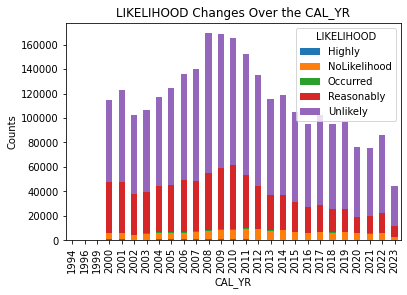

In [47]:
value_counts = violations.groupby('CAL_YR')['LIKELIHOOD'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('LIKELIHOOD Changes Over the CAL_YR')
plt.show()

INSIGHT: This actually does seem like not only are violations going down but so are reasonably likely violations.

#### Inj_Illness

Value assigned to a violation for gravity of injury.  Measure of seriousness of violation being cited as measured by severity of the injury or illness to persons if accident were to occur due to the conditions of the violation: Fatal, LostDays, NoLostDays or Permanent.

In [48]:
violations.INJ_ILLNESS.value_counts(normalize = True)

INJ_ILLNESS
LostDays      0.559744
Fatal         0.170817
Permanent     0.159863
NoLostDays    0.109577
Name: proportion, dtype: float64

INSIGHT: Primarily lostdays, even mix of everything else.

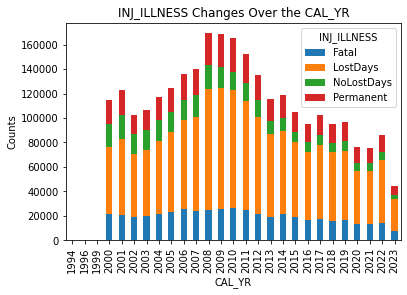

In [49]:
value_counts = violations.groupby('CAL_YR')['INJ_ILLNESS'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('INJ_ILLNESS Changes Over the CAL_YR')
plt.show()

#### Negligence

Codes representing the degree of negligence that the Inspector assigned to the violator due to the violation:  HighNegligence, LowNegligence, ModNegligence, NoNegligence or Reckless. A high degree of negligence is assigned when the operator was in a position to be aware of the condition that contributed to a dangerous situation and there were no mitigating circumstances, or if there are unique aggravating circumstances associated with the violation, such as repeated past violations of the same standard at the mine.

In [44]:
violations.NEGLIGENCE.value_counts(normalize = True)

NEGLIGENCE
ModNegligence     0.783829
LowNegligence     0.149872
HighNegligence    0.064228
NoNegligence      0.001349
Reckless          0.000722
Name: proportion, dtype: float64

INSIGHT: Primarily moderate negligence.

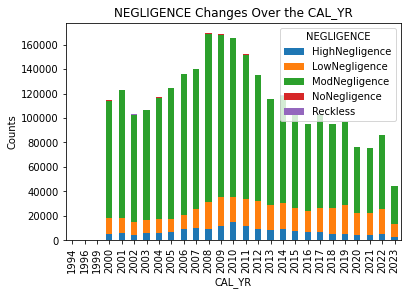

In [45]:
value_counts = violations.groupby('CAL_YR')['NEGLIGENCE'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('NEGLIGENCE Changes Over the CAL_YR')
plt.show()

#### Written Notice

Indicates if this citation is a result of a Miner or Agent notice of complaint to MSHA (written notice 103(g)):  ('Y'  or 'N').  May contain null values.

In [ ]:
violations.WRITTEN_NOTICE.value_counts(normalize = True)

INSIGHT: Very few violations are the result of writer complaints -- meaning they are likely the result of random inspections?

In [ ]:
value_counts = violations.groupby('CAL_YR')['WRITTEN_NOTICE'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('WRITTEN_NOTICE Changes Over the CAL_YR')
plt.show()

INSIGHT: No "No"s until 2005 -- random inspections must have started then.

#### Special Assessment

Specifies whether this citation has been designated for Special Assessment based on Special Assessment Review (Y or N).

In [ ]:
violations.SPECIAL_ASSESS.value_counts(normalize = True)

INSIGHT: Very few violations are designated for Special Assessment -- what is Special Assessment? Is it something about the investigation or the violation? Like follow up required? Or weird type of observation, need it assessed as to whether its a violation or not?

In [ ]:
value_counts = violations.groupby('CAL_YR')['SPECIAL_ASSESS'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('SPECIAL_ASSESS Changes Over the CAL_YR')
plt.show()

INSIGHT: Special assessment only really occured during the Obama administration.

#### Primary or Mill

A code indicating if the Violation was observed in the Primary Mine location or in an associated Mill (Metal/Non-Metal only). May contain null values.

In [ ]:
violations.PRIMARY_OR_MILL.value_counts(normalize = True)

INSIGHT: Most take place in the primary. Need more context here -- what's the difference between the two? What does this tell us? Why would there be nulls?

In [ ]:
value_counts = violations.groupby('CAL_YR')['PRIMARY_OR_MILL'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('PRIMARY_OR_MILL Changes Over the CAL_YR')
plt.show()

#### Asmt Generated

If the violator is an Operator or Contractor, the indicator is 'N'. If the violator is an Agent, the indicator is 'Y'. If the violator is a Miner, the indicator can be 'Y' or 'N'. If none of the above, the indicator is '?'.

In [ ]:
violations.ASMT_GENERATED_IND.value_counts(normalize = True)

INSIGHT: Everything is N? Probably best to drop this column, I think our dataset must be a filtered dataset.

In [ ]:
value_counts = violations.groupby('CAL_YR')['ASMT_GENERATED_IND'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('ASMT_GENERATED_IND Changes Over the CAL_YR')
plt.show()

#### Last Action

Last action taken against this violation such as 1stDemandPrinted, BillingReady, ApprovedforTreasury and Proposed.  

In [ ]:
violations.LAST_ACTION_CD.value_counts(normalize = True)

INSIGHT: Most are paid. 

#### Docket Status

Denotes the current status of this docket:  Approved (approved by the court) or Proposed (not yet been approved by the court).

In [ ]:
violations.DOCKET_STATUS_CD.value_counts(normalize = True)

INSIGHT: Basically everything is accepted.

In [ ]:
value_counts = violations.groupby('CAL_YR')['DOCKET_STATUS_CD'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('DOCKET_STATUS_CD Changes Over the CAL_YR')
plt.show()

INSIGHT: Makes sense that only the most recent data would still be in proposed status -- but no data 2011-2023?

#### Docket Status

Denotes the current status of this docket:  Approved (approved by the court) or Proposed (not yet been approved by the court).

In [ ]:
violations.CONTESTED_IND.value_counts(normalize = True)

INSIGHT: 93% not contested.

In [ ]:
value_counts = violations.groupby('CAL_YR')['CONTESTED_IND'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('CONTESTED_IND Changes Over the CAL_YR')
plt.show()

INSIGHT: Weird that nothing has been contested since 2011? Have the rules changed for contesting?

#### Enforcement Area

Specifies the enforcement areas affected by the violating condition or practice constitute a health hazard, safety hazard, both or other type of hazard. May contain null values.

In [50]:
violations.ENFORCEMENT_AREA.value_counts(normalize = True)

ENFORCEMENT_AREA
Safety             0.952718
Health             0.030132
Other              0.012261
HealthAndSafety    0.004890
Name: proportion, dtype: float64

INSIGHT: 95% are safety violations.

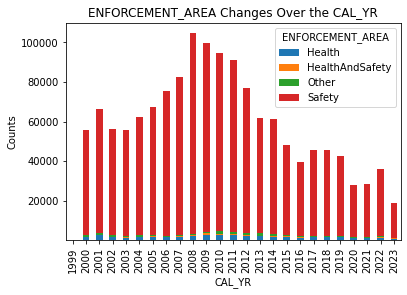

In [51]:
value_counts = violations.groupby('CAL_YR')['ENFORCEMENT_AREA'].value_counts().unstack()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('ENFORCEMENT_AREA Changes Over the CAL_YR')
plt.show()

#### Controller

Name of the controller active at the time the violation was cited.  May contain null values if this record pertains to a violation issued to a contractor.

In [ ]:
controller_valuecounts = violations['CONTROLLER_NAME'].value_counts()
controller_valuecounts_filtered = controller_valuecounts[controller_valuecounts >= 1000]
controller_valuecounts_filtered

#### Section of Act

Section of the Act under which the citation/order was issued.  May contain null values.

In [ ]:
violations.SECTION_OF_ACT.value_counts(normalize = True)

INSIGHT: 33% of violations are under section 316(b) - Should check out that section.

In [ ]:
value_counts = violations['SECTION_OF_ACT'].value_counts()
value_counts.plot(kind='bar', stacked=True)
plt.xlabel('CAL_YR')
plt.ylabel('Counts')
plt.title('SECTION_OF_ACT Volume')
plt.show()

#### Part Section

Code of Federal Regulations: Part/section of Title 30 CFR violated in format PPSSSSSXXXX where (P) Part, (S) Section and (X) Suffix.  Four-digit section numbers are expanded to five within one leading zero.  May contain null values.

In [ ]:
violations['PART_SECTION'].value_counts()

#### Section of Act 1

Primary Section of Act which gives the MSHA Inspector the authority to take the action specified by this Issuance.   More than one type of action may be cited.

In [ ]:
violations['SECTION_OF_ACT_1'].value_counts()

#### Section of Act 2

Secondary Section of Act which gives the MSHA Inspector the authority to take the action specified by this Issuance at Metal/Non-Metal mines only.  More than one type of action may be cited.

In [ ]:
violations['SECTION_OF_ACT_2'].value_counts()

#### Initial Viol No.

This is the preceding citation record when there is a need to relate a citation to a previous one. For example this would apply when an order follows a citation. This relationship is needed to calculate the good faith reduction penalty points.  May contain null values.

In [ ]:
violations['INITIAL_VIOL_NO'].value_counts()

#### Replaced by Order No.

Order number which replaced the original citation.  May contain null values if situation does not apply.

In [ ]:
violations['REPLACED_BY_ORDER_NO'].value_counts()

### Bivariate EDA

#### Violator Type: Number Affected

In [ ]:
sns.catplot(x="NO_AFFECTED", y="VIOLATOR_TYPE_CD", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('VIOLATOR_TYPE_CD').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

INSIGHT: On average operator has more number affected, but unclear at this point if statistically significant difference (especially considering operator has way more violations).

#### Violator Type: Proposed Penalty

In [ ]:
sns.catplot(x="PROPOSED_PENALTY", y="VIOLATOR_TYPE_CD", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('VIOLATOR_TYPE_CD').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

INSIGHT: On average operator has a higher proposed penalty, but unclear at this point if statistically significant difference (especially considering operator has way more violations).

#### Coal Metal: Number Affected

In [ ]:
sns.catplot(x="NO_AFFECTED", y="COAL_METAL_IND", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('COAL_METAL_IND').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

INSIGHT: On average, coal has more affected. Seems big enough to be significant but have to see.

#### Coal Metal: Proposed Penalty

In [ ]:
sns.catplot(x="PROPOSED_PENALTY", y="COAL_METAL_IND", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('COAL_METAL_IND').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

INSIGHT: On average, coal has a way higher proposed penalty.

#### Sig Sub: Number Affected

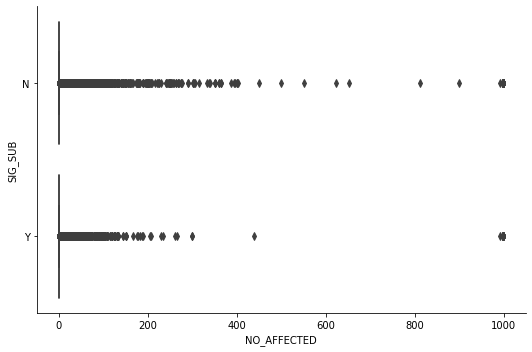

In [31]:
sns.catplot(x="NO_AFFECTED", y="SIG_SUB", data=violations, kind="box", aspect=1.5)
plt.show()

In [32]:
violations.groupby('SIG_SUB').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

NO_AFFECTED               
                min      mean  max
SIG_SUB                           
N                 0  1.473819  999
Y                 0  1.589285  999

In [40]:
yessig = violations[violations["SIG_SUB"] == "Y"]
nosig = violations[violations["SIG_SUB"] == "N"]


In [42]:
yessig = yessig[['NO_AFFECTED']]
nosig = nosig[['NO_AFFECTED']]

INSIGHT: Definitely expected to see a bigger difference here!

In [43]:
from statsmodels.stats.weightstats import ztest as ztest


ztest(yessig, nosig, value=0) 


(array([13.62202339]), array([2.96244713e-42]))

#### Sig Sub: Proposed Penalty

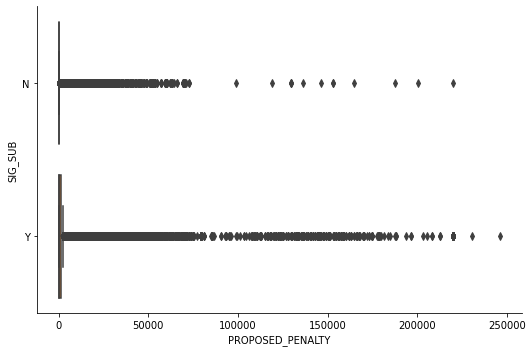

In [33]:
sns.catplot(x="PROPOSED_PENALTY", y="SIG_SUB", data=violations, kind="box", aspect=1.5)
plt.show()

In [34]:
violations.groupby('SIG_SUB').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

PROPOSED_PENALTY                       
                     min         mean       max
SIG_SUB                                        
N                   50.0   250.838715  220000.0
Y                    1.0  1473.164205  246200.0

INSIGHT: Now here is a big difference!

#### Section of Act: Number Affected

In [ ]:
violations.groupby('SECTION_OF_ACT').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

#### Section of Act: Proposed Penalty

In [ ]:
violations.groupby('SECTION_OF_ACT').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

#### Likelihood: Number Affected

In [ ]:
sns.catplot(x="NO_AFFECTED", y="LIKELIHOOD", data=violations, kind="box", aspect=1.5)
plt.show()


In [ ]:
violations.groupby('LIKELIHOOD').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

INSIGHT: High likely things impact more people on average.

#### Likelihood: Proposed Penalty

In [ ]:
sns.catplot(x="PROPOSED_PENALTY", y="LIKELIHOOD", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('LIKELIHOOD').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

#### Injury Illness: Number Affected

In [ ]:
sns.catplot(x="NO_AFFECTED", y="INJ_ILLNESS", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('INJ_ILLNESS').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

#### Injury Illness: Proposed Penalty

In [ ]:
sns.catplot(x="PROPOSED_PENALTY", y="INJ_ILLNESS", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('INJ_ILLNESS').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

INSIGHT: The worse the injury/impact, the higher the penalty.

#### Negligence: Number Affected

In [ ]:
sns.catplot(x="NO_AFFECTED", y="NEGLIGENCE", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('NEGLIGENCE').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

INSIGHT: Reckless violations affect more people on average.

#### Negligence: Proposed Penalty

In [ ]:
sns.catplot(x="PROPOSED_PENALTY", y="NEGLIGENCE", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('NEGLIGENCE').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

INSIGHT: Reckless and highly negligent actions carry higher penalties.

#### Enforcement Area: Number Affected

In [ ]:
sns.catplot(x="NO_AFFECTED", y="ENFORCEMENT_AREA", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('ENFORCEMENT_AREA').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

#### Enforcement Area: Proposed Penalty

In [ ]:
sns.catplot(x="PROPOSED_PENALTY", y="ENFORCEMENT_AREA", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('ENFORCEMENT_AREA').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

INSIGHT: Health AND safety violations carry high penalties -- makes sense, they're double whammies!

#### Contested: Number Affected

In [ ]:
sns.catplot(x="NO_AFFECTED", y="CONTESTED_IND", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('CONTESTED_IND').agg({'NO_AFFECTED': ['min', 'mean', 'max']})

INSIGHT: Interesting -- I wouldn't have that that contested violations would have affected more people on average!

#### Contested: Proposed Penalty

In [ ]:
sns.catplot(x="PROPOSED_PENALTY", y="CONTESTED_IND", data=violations, kind="box", aspect=1.5)
plt.show()

In [ ]:
violations.groupby('CONTESTED_IND').agg({'PROPOSED_PENALTY': ['min', 'mean', 'max']})

INSIGHT: Interesting -- People contest higher proposed violations!

In [61]:
signeg= pd.crosstab(violations['SIG_SUB'], violations['NEGLIGENCE'])
signeg

NEGLIGENCE,HighNegligence,LowNegligence,ModNegligence,NoNegligence,Reckless
SIG_SUB,,,,,
N,107028,340032,1552342,2642,498
Y,70778,74878,617699,1092,1500


<AxesSubplot: xlabel='NEGLIGENCE', ylabel='SIG_SUB'>

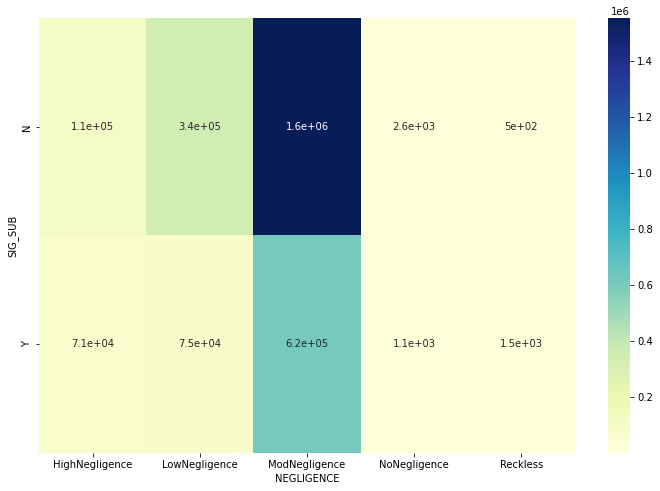

In [62]:
plt.figure(figsize=(12,8))
sns.heatmap(signeg, annot=True, cmap="YlGnBu")

In [63]:
c, p, dof, expected = chi2_contingency(signeg)
print(c)
print(p)
print(dof)

35219.70644175799
0.0
4


In [72]:
siglike= pd.crosstab(violations['SIG_SUB'], violations['LIKELIHOOD'])
siglike

LIKELIHOOD,Highly,NoLikelihood,Occurred,Reasonably,Unlikely
SIG_SUB,,,,,
N,132,145437,372,10571,1846028
Y,15034,516,5829,742357,2187


<AxesSubplot: xlabel='LIKELIHOOD', ylabel='SIG_SUB'>

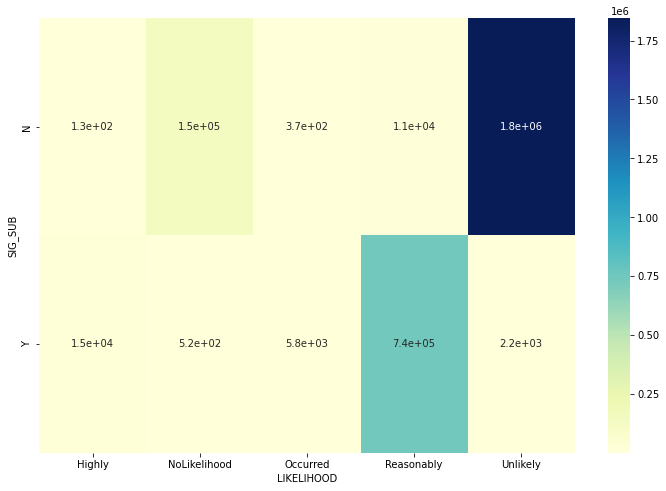

In [73]:
plt.figure(figsize=(12,8))
sns.heatmap(siglike, annot=True, cmap="YlGnBu")

In [74]:
c, p, dof, expected = chi2_contingency(siglike)
print(c)
print(p)
print(dof)

2700494.98916361
0.0
4


In [68]:
siginj= pd.crosstab(violations['SIG_SUB'], violations['INJ_ILLNESS'])
siginj

INJ_ILLNESS,Fatal,LostDays,NoLostDays,Permanent
SIG_SUB,,,,
N,293087,1140672,302744,266037
Y,179817,408972,618,176537


<AxesSubplot: xlabel='INJ_ILLNESS', ylabel='SIG_SUB'>

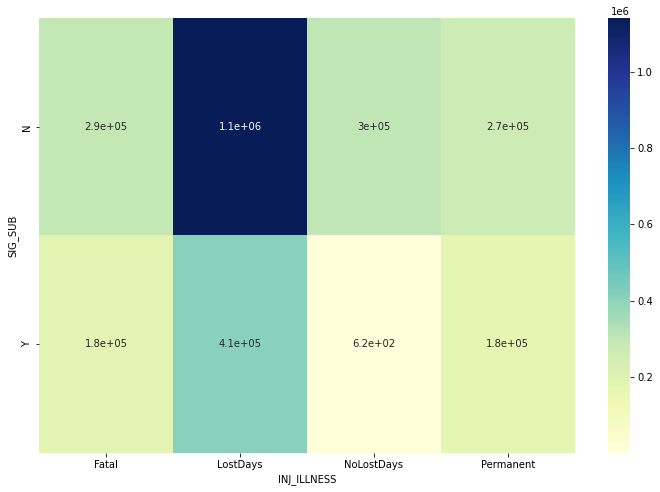

In [69]:
plt.figure(figsize=(12,8))
sns.heatmap(siginj, annot=True, cmap="YlGnBu")

In [71]:
c, p, dof, expected = chi2_contingency(siginj)
print(c)
print(p)
print(dof)

173974.83332500013
0.0
3


## Violations + Inspections + Mines Dataset

In [ ]:
violations_inspections_mines = pd.merge(violations, inspections_mines ,on= 'EVENT_NO')
violations_inspections_mines

In [ ]:
# MINE_TYPE stacked bar plot with CURRENT_MINE_TYPE from Mines data
 
fig, ax = plt.subplots()

violations['MINE_TYPE'].value_counts().plot(kind='bar', color='r', ax=ax, label='Violations', stacked=True)
mines['CURRENT_MINE_TYPE'].value_counts().plot(kind='bar', color='b', ax=ax, label='Current Mine Type', stacked=True)

ax.set_xlabel('Mine Type')
ax.set_ylabel('Count')
ax.set_title('Mine Type Counts')
ax.legend()

plt.show()


INSIGHT:
From the stacked bar plot above, we can see that there are clearly more violations occuring per mine type than there are actual mines, indicating that mines, of all types, often have more than one violation per mine. But, the mine types still appear to be relatively proportional number of violations per mine type. For example, surface mines have the most mines, and appear to also have the most violations, which makes sense. On the otherhand, facility mines, which have the least number of mines, also appear to have the least number of violations. 